# **Heart Disease Prediction**

## **Feature Engineering**

This notebook focuses on performing feature engineering to prepare the dataset for model training. The goal is to clean, transform, and modify the data to ensure its predictive power.

### **Feature Engineering Process**

- **Data Cleaning:** Handling missing values, removing duplicates, and addressing outliers if necessary.
- **Feature Selection:** Eliminating redundant or uninformative attributes.
- **Feature Engineering:** Transforming variables, discretizing continuous features, creating new meaningful attributes, and applying mathematical transformations where appropriate.
- **Feature Scaling:** Standardizing or normalizing numerical features.
- **Encoding:** Converting categorical variables into numerical representations suitable for modeling.

All transformations will be implemented using **scikit-learn pipelines** to ensure a structured and reproducible workflow.

`Simón Correa Marín`


### **1. Import Libraries and Configurations**


In [1]:
# base libraries for data science

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

### **2. Load Data**


In [2]:
DATA_DIR = Path.cwd().resolve().parents[0] / "data"

hd_df = pd.read_parquet(DATA_DIR / "02_intermediate/hd_type_fixed.parquet", engine="pyarrow")

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)
print("sklearn version: ", sk.__version__)

Pandas version:  2.2.3
sklearn version:  1.6.1


### **3. Data Preparation**


In [4]:
hd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rest_ecg    6392 non-null   category
 1   ca          6479 non-null   float64 
 2   thal        6552 non-null   category
 3   max_hr      6453 non-null   float64 
 4   exang       6848 non-null   bool    
 5   old_peak    6493 non-null   float64 
 6   chol        6643 non-null   float64 
 7   rest_bp     6655 non-null   float64 
 8   chest_pain  6648 non-null   category
 9   disease     6848 non-null   bool    
 10  sex         6692 non-null   category
 11  fbs         6848 non-null   bool    
 12  slope       6492 non-null   float64 
 13  age         6763 non-null   float64 
dtypes: bool(3), category(4), float64(7)
memory usage: 422.0 KB


I won't be deleting any columns for now.


#### **Missing Values**


In [5]:
hd_df.isna().sum()

rest_ecg      456
ca            369
thal          296
max_hr        395
exang           0
old_peak      355
chol          205
rest_bp       193
chest_pain    200
disease         0
sex           156
fbs             0
slope         356
age            85
dtype: int64

#### **Duplicated Data**


In [6]:
duplicate_rows = hd_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  6340


In [7]:
hd_df = hd_df.drop_duplicates()
hd_df.shape

(508, 14)

There are 508 rows left after deleting duplicated rows


In [8]:
# Missing values after dropping duplicates
hd_df.isna().sum()

rest_ecg      143
ca             89
thal           74
max_hr        121
exang           0
old_peak      107
chol           60
rest_bp        56
chest_pain     58
disease         0
sex            43
fbs             0
slope         107
age            17
dtype: int64

### **3. Feature Engineering**


In [9]:
# Encode target variable
hd_df["disease"] = hd_df["disease"].astype("int64")
# True = 1, False = 0

In [10]:
hd_df.sample(5)

,rest_ecg,ca,thal,max_hr,exang,old_peak,chol,rest_bp,chest_pain,disease,sex,fbs,slope,age
692,NaN,NaN,NaN,NaN,True,NaN,315.0,136.0,asymptomatic,1,Male,False,NaN,42.0
1787,normal,0.0,normal,171.0,False,0.9,240.0,150.0,typical,1,Female,False,1.0,60.0
71,normal,1.0,reversable,151.0,False,1.0,277.0,118.0,nonanginal,0,Male,False,1.0,68.0
99,normal,1.0,reversable,143.0,True,3.0,335.0,110.0,asymptomatic,1,Male,False,2.0,57.0
45,normal,3.0,reversable,122.0,True,4.2,298.0,140.0,asymptomatic,1,Male,False,2.0,51.0


In [11]:
nom_categorical_cols = ["chest_pain", "rest_ecg", "thal", "sex"]
ord_categorical_cols = ["ca", "slope"]
disc_numerical_cols = ["age", "max_hr", "chol", "rest_bp"]
cont_numerical_cols = ["old_peak"]
boolean_cols = ["exang", "fbs"]

In [12]:
# hd_df[['ca', 'slope']] = hd_df[['ca', 'slope']].astype("float")

#### **Removing Outliers**


From EDA we got these suspecting outliers

- Maxhr - 71
- old_peak > 4
- colesterol > 400
- rest_bp > 180


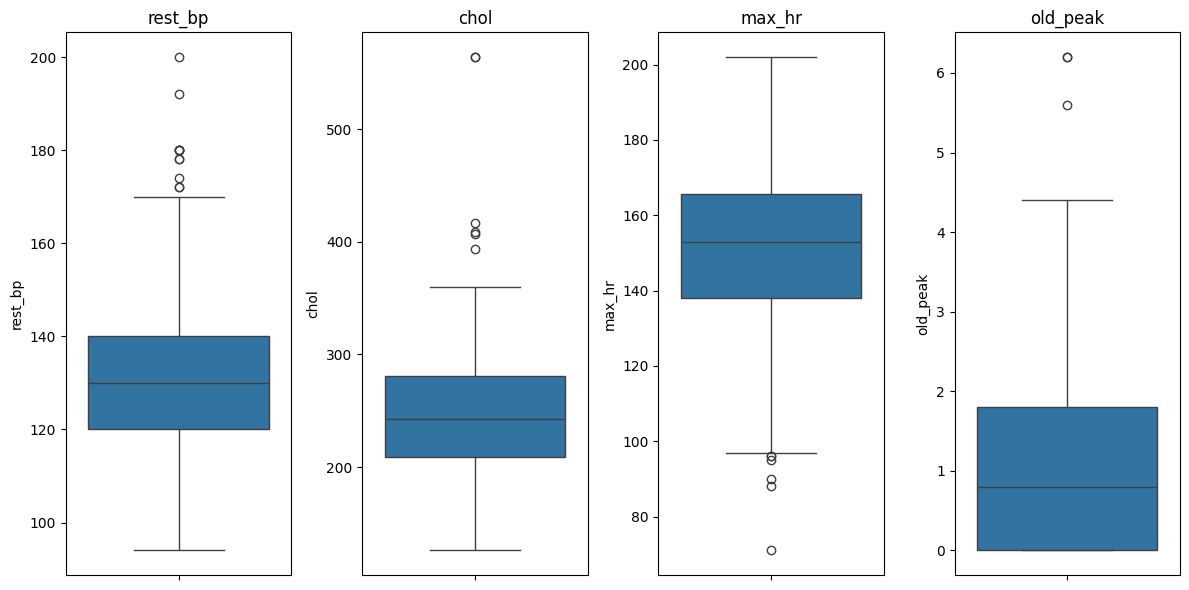

In [13]:
variables = ["rest_bp", "chol", "max_hr", "old_peak"]
plt.figure(figsize=(12, 6))
# Boxplot
for i, var in enumerate(variables, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=hd_df[var])
    plt.title(var)

plt.tight_layout()
plt.show()

After a research, these values are extremely rare but possible, due to some illnesses like low heart rate, hypercholistemia and hypertension, so I decide I won't drop them.


#### **Pipeline**


In [ ]:
from sklearn.preprocessing import FunctionTransformer

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

ord_categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

boolean_pipe = Pipeline(
    steps=[
        (
            "to_int",
            FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one"),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols + cont_numerical_cols),
        ("nominal_categoric", nom_categorical_pipe, nom_categorical_cols),
        ("ordinal_categoric", ord_categorical_ord_pipe, ord_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
    ]
)

In [15]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'max_hr', 'chol', 'rest_bp',
                                  'old_peak']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['chest_pain', 'rest_ecg', 'thal', 'sex']),
                                ('ordinal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['ca', 'slope']),
                                ('boolean',
                                 Pipeline(steps=[('to_int',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x131aa1440>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['exang', 'fbs'])])

### **Preprocessing Pipeline**

This preprocessing pipeline transforms a dataset related to heart disease, ensuring that all variables are handled appropriately according to their type (numeric, nominal categorical, ordinal categorical, and boolean).

#### **1️. Numeric Pipeline**

- **Columns:** `["age", "max_hr", "chol", "rest_bp", "old_peak"]`
- **Steps:**
  - `SimpleImputer(strategy="median")`: Imputes missing values using the median of each numeric column.

#### **2️. Nominal Categorical Pipeline**

- **Columns:** `["chest_pain", "rest_ecg", "thal", "sex"]`
- **Steps:**
  - `SimpleImputer(strategy="most_frequent")`: Imputes missing values using the most frequent category in each column.
  - `OneHotEncoder(drop="if_binary")`: Encodes categorical variables using one-hot encoding, dropping one category if the variable is binary.

#### **3️. Ordinal Categorical Pipeline**

- **Columns:** `["ca", "slope"]`
- **Steps:**
  - `SimpleImputer(strategy="most_frequent")`: Imputes missing values using the most frequent category.
  - `OrdinalEncoder()`: Transforms ordinal variables into numerical values while preserving their order.

#### **4️. Boolean Pipeline**

- **Columns:** `["exang", "fbs"]`
- **Steps:**
  - `FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one")`: Converts boolean values into integers (`0` and `1`).
  - `SimpleImputer(strategy="most_frequent")`: Fills missing values using the most frequent category.
  - `OneHotEncoder(drop="if_binary")`: Applies one-hot encoding, dropping one category if the variable is binary.

#### **5️. Column Transformer**

Combines all previous transformations into a single preprocessing pipeline:

- **Numeric variables** → `numeric_pipe`
- **Nominal categorical variables** → `nom_categorical_pipe`
- **Ordinal categorical variables** → `ord_categorical_ord_pipe`
- **Boolean variables** → `boolean_pipe`


#### **Train/Test split**


In [16]:
X_features = hd_df.drop("disease", axis="columns")
Y_target = hd_df["disease"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [17]:
x_train.shape, y_train.shape

((406, 13), (406,))

In [18]:
x_test.shape, y_test.shape

((102, 13), (102,))

In [19]:
print(x_train.dtypes)

rest_ecg      category
ca             float64
thal          category
max_hr         float64
exang             bool
old_peak       float64
chol           float64
rest_bp        float64
chest_pain    category
sex           category
fbs               bool
slope          float64
age            float64
dtype: object


#### **Preprocessing Pipeline**


In [20]:
transformed_data = preprocessor.fit(x_train)

In [21]:
feature_names = preprocessor.get_feature_names_out()

# Transform X_test with preprocessor and pandas output set
x_train_transformed = preprocessor.transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=feature_names)
x_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 20 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   numeric__age                                               406 non-null    float64
 1   numeric__max_hr                                            406 non-null    float64
 2   numeric__chol                                              406 non-null    float64
 3   numeric__rest_bp                                           406 non-null    float64
 4   numeric__old_peak                                          406 non-null    float64
 5   nominal_categoric__chest_pain_asymptomatic                 406 non-null    float64
 6   nominal_categoric__chest_pain_nonanginal                   406 non-null    float64
 7   nominal_categoric__chest_pain_nontypical                   406 non-null    float64
 8   nominal_ca

In [22]:
x_train_transformed.head()

,numeric__age,numeric__max_hr,numeric__chol,numeric__rest_bp,numeric__old_peak,nominal_categoric__chest_pain_asymptomatic,nominal_categoric__chest_pain_nonanginal,nominal_categoric__chest_pain_nontypical,nominal_categoric__chest_pain_typical,nominal_categoric__rest_ecg_ST-T wave abnormality,nominal_categoric__rest_ecg_left ventricular hypertrophy,nominal_categoric__rest_ecg_normal,nominal_categoric__thal_fixed,nominal_categoric__thal_normal,nominal_categoric__thal_reversable,nominal_categoric__sex_Male,ordinal_categoric__ca,ordinal_categoric__slope,boolean__exang_1,boolean__fbs_1
0,67.0,163.0,243.0,130.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0
1,60.0,142.0,243.0,130.0,2.8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0
2,44.0,177.0,197.0,110.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,52.0,158.0,201.0,134.0,0.8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,44.0,188.0,219.0,130.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
x_train.head()

,rest_ecg,ca,thal,max_hr,exang,old_peak,chol,rest_bp,chest_pain,sex,fbs,slope,age
410,NaN,2.0,reversable,163.0,False,0.2,NaN,NaN,NaN,NaN,True,2.0,67.0
1482,NaN,2.0,reversable,142.0,True,2.8,NaN,NaN,NaN,NaN,True,2.0,60.0
903,left ventricular hypertrophy,1.0,normal,177.0,False,0.0,197.0,110.0,NaN,Male,False,1.0,44.0
0,normal,1.0,normal,158.0,False,0.8,201.0,134.0,nontypical,Male,False,1.0,52.0
183,left ventricular hypertrophy,0.0,normal,188.0,False,0.0,219.0,130.0,nontypical,Male,False,1.0,44.0


### **4. Conclusions and results**


- Decided to don't drop any outliers beacuse the health field possibilities.
- Made a pipeline to handle every data type.
- Ended up with 20 columns after transformation process.
